In [2]:
import keras
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt


Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

In [3]:
#Load MNIST data

dataset_name = "mnist_3_vs_8"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = { 3, 8 }

(X_train, y_train), (X_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

original_test_idx = np.arange(X_test.shape[0])

X_train = X_train[keep_index_train]
X_test = X_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]
original_test_idx = original_test_idx[keep_index_test]

n_train = int((X_train.shape[0] // batch_size) * batch_size)
n_test = int((X_test.shape[0] // batch_size) * batch_size)
X_train = X_train[:n_train]
X_test = X_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]
original_test_idx = original_test_idx[:n_test]


X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print("x_train.shape = " + str(X_train.shape))

print("n train samples = " + str(X_train.shape[0]))
print("n test samples = " + str(X_test.shape[0]))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

X_train = _binarize_images(X_train, val_thresh=0.5)
X_test = _binarize_images(X_test, val_thresh=0.5)


x_train.shape = (11968, 28, 28, 1)
n train samples = 11968
n test samples = 1984


In [4]:
#Re-make one-hot targets into int labels

y_train = np.argmax(y_train, axis=-1)
y_test = np.argmax(y_test, axis=-1)


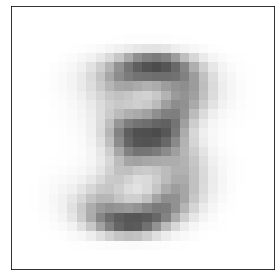

In [5]:
#Visualize background image distribution

pseudo_count = 1.0

X_mean = (np.sum(X_train, axis=(0, 3)) + pseudo_count) / (X_train.shape[0] + pseudo_count)
X_mean_logits = np.log(X_mean / (1. - X_mean))

f = plt.figure(figsize=(4, 4))

plot_ix = 0

plt.imshow(X_mean, cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.show()


In [6]:
#Load predictor model

saved_model_file = "saved_models/mnist_binarized_cnn_10_digits.h5"

keras_model = Sequential()

keras_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d_1'))
keras_model.add(Conv2D(64, (3, 3), activation='relu', name='conv2d_2'))
keras_model.add(MaxPooling2D(pool_size=(2, 2)))
keras_model.add(Dropout(0.25))
keras_model.add(Flatten())
keras_model.add(Dense(128, activation='relu', name='dense_1'))
keras_model.add(Dropout(0.5))
keras_model.add(Dense(num_classes, activation='linear', name='dense_2'))
keras_model.add(Activation('softmax'))

keras_model.load_weights(saved_model_file)
keras_model.trainable = False

keras_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
#DeepLIFT Notebook Cell 5

import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc

#Three different models, one each for RevealCancel, Gradient and GuidedBackprop
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)
grad_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.Gradient)
guided_backprop_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.GuidedBackprop)


nonlinear_mxts_mode is set to: RevealCancel


/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/deeplift/conversion/kerasapi_conversion.py:352: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  str_data = h5py.File(h5_file).attrs["model_config"]
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/deeplift/conversion/kerasapi_conversion.py:359: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs f

Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: Gradient
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: GuidedBackprop
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case


In [8]:
#DeepLIFT Notebook Cell 6

from deeplift.util import compile_func
import numpy as np
from keras import backend as K

deeplift_model = revealcancel_model
deeplift_prediction_func = compile_func([deeplift_model.get_layers()[0].get_activation_vars()],
                                       deeplift_model.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(X_test, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[X_test],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions


difference in predictions: 0.0


In [9]:
#DeepLIFT Notebook Cell 7
#Altered: We compute the multipliers rather than masked scores multipliers

from keras import backend as K
import deeplift
from deeplift.util import get_integrated_gradients_function

revealcancel_func = revealcancel_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)
grad_times_inp_func = grad_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)
guided_backprop_times_inp_func = guided_backprop_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)

gradient_func = grad_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)
guided_backprop_func = guided_backprop_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)

#pure-gradients or pure-guidedbackprop perform rather poorly because they produce scores on pixels that are 0 (which are
#the backround in MNIST). But we can give them a slight advantage by masking out positions that
#are zero. Also, the method of simonyan et al uses the magnitude of the gradient.
simonyan_func_masked = lambda input_data_list, **kwargs: ((input_data_list[0]>0.0)*
                        np.abs(np.array(gradient_func(input_data_list=input_data_list,**kwargs))))
guided_backprop_func_masked = lambda input_data_list, **kwargs: ((input_data_list[0]>0.0)*
                               guided_backprop_func(input_data_list=input_data_list, **kwargs))

#prepare the integrated gradients scoring functions
#heads-up: these take 5x and 10x longer to compute respectively!
integrated_grads_5 = get_integrated_gradients_function(gradient_func, 5)
integrated_grads_10 = get_integrated_gradients_function(gradient_func, 10)


TARGET LAYER SET TO preact_7
TARGET LAYER SET TO preact_7
TARGET LAYER SET TO preact_7
TARGET LAYER SET TO preact_7
TARGET LAYER SET TO preact_7


In [10]:
#DeepLIFT Notebook Cell 8
#Altered: We only compute scores for task_idx 3 and 8
#Altered: Use non-masked functions for simonyan and guided backprop
#Altered: Use the mean as background distribution

#Tile the ref background to same shape as test set
X_mean_tiled_test = np.tile(np.expand_dims(np.expand_dims(X_mean, axis=0), axis=-1), (X_test.shape[0], 1, 1, 1))

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
print("HEADS UP! integrated_grads_5 and integrated_grads_10 take 5x and 10x longer to run respectively")
print("Consider leaving them out to get faster results")
for method_name, score_func in [
                               ('revealcancel', revealcancel_func),
                               #('guided_backprop_masked', guided_backprop_func),
                               ('guided_backprop_times_inp', guided_backprop_times_inp_func),
                               #('simonyan_masked', gradient_func), 
                               ('grad_times_inp', grad_times_inp_func),
                               ('integrated_grads_5', integrated_grads_5),
                               ('integrated_grads_10', integrated_grads_10)
]:
    print("Computing scores for:",method_name)
    method_to_task_to_scores[method_name] = {}
    for task_idx in [3, 8] :
        print("\tComputing scores for task: "+str(task_idx))
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[X_test],
                    input_references_list=[X_mean_tiled_test],#[np.zeros_like(X_test)],
                    batch_size=1000,
                    progress_update=None))
        method_to_task_to_scores[method_name][task_idx] = scores


HEADS UP! integrated_grads_5 and integrated_grads_10 take 5x and 10x longer to run respectively
Consider leaving them out to get faster results
Computing scores for: revealcancel
	Computing scores for task: 3
	Computing scores for task: 8
Computing scores for: guided_backprop_times_inp
	Computing scores for task: 3
	Computing scores for task: 8
Computing scores for: grad_times_inp
	Computing scores for task: 3
	Computing scores for task: 8
Computing scores for: integrated_grads_5
	Computing scores for task: 3
	Computing scores for task: 8
Computing scores for: integrated_grads_10
	Computing scores for task: 3
	Computing scores for task: 8


In [11]:
#Load Scrambler importance scores

scrambler_scores_3_vs_8_file = "autoscrambler_dataset_mnist_3_vs_8_n_samples_32_resnet_5_4_32_3_00_n_epochs_50_target_bits_0005_kl_divergence_higher_entropy_penalty_importance_scores_test.npy"

scrambler_scores_3_vs_8 = np.load(scrambler_scores_3_vs_8_file)

method_to_task_to_scores['scrambler'] = {}
method_to_task_to_scores['scrambler'][8] = scrambler_scores_3_vs_8
method_to_task_to_scores['scrambler'][3] = np.zeros(scrambler_scores_3_vs_8.shape)

scrambler_inverted_scores_3_vs_8_file = "autoscrambler_dataset_mnist_3_vs_8_inverted_scores_n_samples_32_resnet_5_4_32_3_00_n_epochs_50_target_bits_03_kl_divergence_higher_entropy_penalty_importance_scores_test.npy"

scrambler_inverted_scores_3_vs_8 = np.load(scrambler_inverted_scores_3_vs_8_file)

method_to_task_to_scores['scrambler_inverted'] = {}
method_to_task_to_scores['scrambler_inverted'][8] = scrambler_inverted_scores_3_vs_8
method_to_task_to_scores['scrambler_inverted'][3] = np.zeros(scrambler_inverted_scores_3_vs_8.shape)



In [14]:
#DeepLIFT Notebook Cell 9

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras import backend as K


#Function to plot scores of an MNIST figure
def viz_scores(scores,ax):
    reshaped_scores = scores.reshape(28,28)
    the_min = np.min(reshaped_scores)
    the_max = np.max(reshaped_scores)
    center = 0.0
    negative_vals = (reshaped_scores <= 0.0)*reshaped_scores/(the_min + 10**-7)
    positive_vals = (reshaped_scores > 0.0)*reshaped_scores/float(the_max + 10**-7)
    reshaped_scores = -negative_vals + positive_vals
    ax.imshow(-reshaped_scores, cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])

#Function that masks out the top n pixels where the score for
#task_1 is higher than the score for task_2
def get_masked_image(idx, scores, task_1, task_2, n_to_erase):
    difference = scores[task_1][idx].ravel() - scores[task_2][idx].ravel()
    #highlight the top n
    top_nth_threshold = max(sorted(difference, key=lambda x: -x)[n_to_erase],0.0)
    thresholded_points = 1.0*(difference <= top_nth_threshold)
    masked_inp = thresholded_points.reshape(28,28,1)*X_test[idx]
    return masked_inp

#Function to plot the result of masking on a single example, for converting
#from task1->task2 and task1->task3
def plot_two_way_figures(idx, task_1, task_2, task_3, method_names, n_to_erase):
    print("example index: "+str(idx))
    print("Order of columns is:","task "+str(task_1)+" scores","task "+str(task_2)+" scores",
                                 str(task_1)+"->"+str(task_2)+" masking",
                                 "task "+str(task_3)+" scores", str(task_1)+"->"+str(task_3)+" masking")
    print("Order of the methods is: "+", ".join(str(x) for x in method_names))
    for method_name in method_names:
        scores = method_to_task_to_scores[method_name]
        mean_scores_over_all_tasks = np.zeros(scores[task_1][idx].shape)#np.mean(np.array([scores[i][idx] for i in range(10)]), axis=0)
        f, axarr = plt.subplots(1, 6, sharey=False, figsize=(15,10))
        viz_scores(X_test[idx], axarr[0])      
        viz_scores(scores[task_1][idx] - mean_scores_over_all_tasks, axarr[1])
        viz_scores(scores[task_2][idx] - mean_scores_over_all_tasks, axarr[2])
        viz_scores(get_masked_image(idx, scores, task_1, task_2, n_to_erase), axarr[3])
        viz_scores(scores[task_3][idx] - mean_scores_over_all_tasks, axarr[4])
        viz_scores(get_masked_image(idx, scores, task_1, task_3, n_to_erase), axarr[5])
    plt.show()
    
#Function to compute change in log-odds scores after
#pixels have been masked to convert from original_class to target_class
def compute_delta_log_odds(X, y, predict_func, imp_scores,
                           original_class, target_class,
                           num_perturbations):
    original_class_mask = y_test==original_class
    X = np.compress(condition=original_class_mask,
                    a=X,axis=0)
    
    
    #compute log-odds of model for those two classes
    predictions = np.array(deeplift.util.run_function_in_batches(predict_func,
                                                        input_data_list=[X],
                                                        batch_size=200, progress_update=None))
    orig_log_odds = predictions[:,original_class] - predictions[:,target_class]
    
    #make num_perturbations to move from original_class
    #to target_class according to imp_scores
    #first, get the difference of imp_scores for the two classes
    diff_of_scores = (np.compress(original_class_mask, imp_scores[original_class].reshape((-1, 784)), axis=0) - 
                      np.compress(original_class_mask, imp_scores[target_class].reshape((-1, 784)), axis=0))
    modified_inp = []
    #then, for each example, sort the scores and zero out indices
    for inp, diff_of_scores in zip(X, diff_of_scores):
        top_nth_threshold = max(sorted(diff_of_scores, key=lambda x: -x)[num_perturbations], 0.0)
        thresholded_points = 1.0*(diff_of_scores <= top_nth_threshold)
        modified_inp.append(thresholded_points.reshape(28,28,1)*inp)
    modified_inp = np.array(modified_inp)
    
    #assess change in log-odds for the modified images
    new_predictions = np.array(deeplift.util.run_function_in_batches(predict_func,
                                                        input_data_list=[modified_inp],
                                                        batch_size=200, progress_update=None))
    new_log_odds = new_predictions[:,original_class] - new_predictions[:,target_class]
    
    to_return = orig_log_odds - new_log_odds
    
    return (to_return,
            sum(new_log_odds < 0.0)/float(len(new_log_odds)),
            new_predictions[:,[original_class, target_class]],
            predictions[:,[original_class, target_class]])

#pre_softmax_func computes the output of the linear layer preceding the
#Final softmax noninearity
pre_softmax_func_inner = K.function([keras_model.input, K.learning_phase()],
                                    [keras_model.layers[-2].output])
pre_softmax_func = lambda x: pre_softmax_func_inner(x+[False])[0]

def barplot_scores(original_class, target_class, method_names_and_short_names, n_to_erase):
    print("converting: "+str(original_class)+"->"+str(target_class))
    method_names = [x[0] for x in method_names_and_short_names]
    short_names = [x[1] for x in method_names_and_short_names]
    original_class_mask = y_test==original_class
    scores_to_plot = []
    fig, ax = plt.subplots(figsize=(2*len(method_names),5))
    for method_name in method_names:
        logodds_diff, flipped, new_predictions, old_predictions = compute_delta_log_odds(
                                                                     X=X_test, y=y_test,
                                                                     predict_func=pre_softmax_func,
                                                                     imp_scores=method_to_task_to_scores[method_name],
                                                                     original_class=original_class,
                                                                     target_class=target_class,
                                                                     num_perturbations=n_to_erase)
        #figure out indices with big shifts
        retained_indices = np.compress(condition=original_class_mask, a=np.arange(len(y_test)))
        
        #sorted_shifts
        sorted_shifts = sorted(enumerate(zip(logodds_diff,new_predictions,old_predictions)), key=lambda x: -x[1][0])
        print("top indices for "+str(method_name)+": "+" ".join([str(retained_indices[x[0]]) for x in sorted_shifts[:10]]))
        scores_to_plot.append(logodds_diff)
        
    ax.boxplot(scores_to_plot, widths=[0.5 for x in method_names])
    #ax.set_ylim(-1000,17000)
    ax.set_ylabel("Change in log-odds")
    ax.set_xticklabels(short_names)
    plt.title(str(original_class)+" --> "+str(target_class), fontsize=24)
    plt.tick_params(labelsize=17)
    plt.show()


example index: 1154
Order of columns is: task 8 scores task 3 scores 8->3 masking task 8 scores 8->8 masking
Order of the methods is: grad_times_inp, guided_backprop_times_inp, integrated_grads_5, revealcancel, scrambler, scrambler_inverted


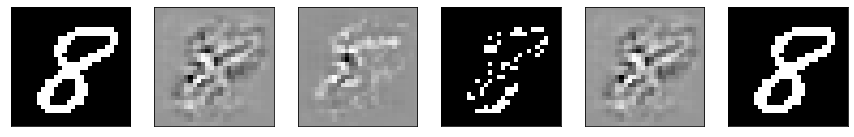

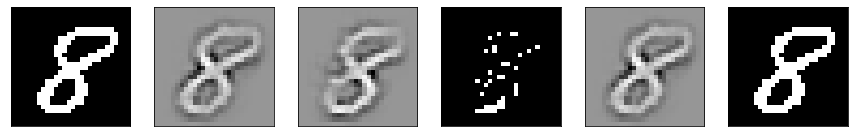

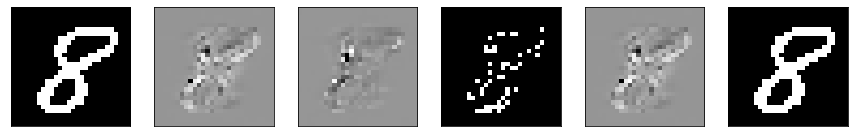

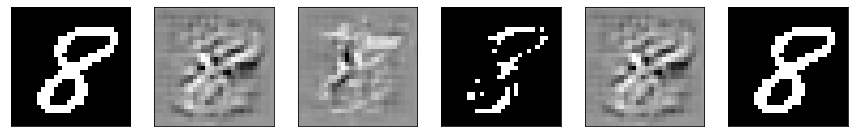

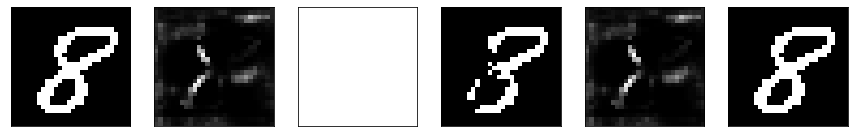

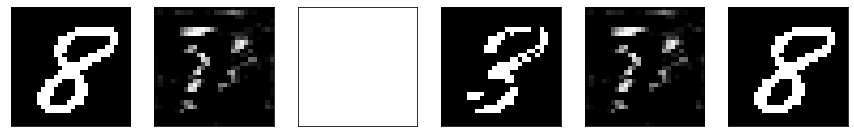

In [15]:
#DeepLIFT Notebook Cell 10

n_to_erase=157
#method_names = ['simonyan_masked', 'guided_backprop_masked', 'grad_times_inp', 'integrated_grads_5', 'revealcancel', 'scrambler']
method_names = ['grad_times_inp', 'guided_backprop_times_inp', 'integrated_grads_5', 'revealcancel', 'scrambler', 'scrambler_inverted']
plot_two_way_figures(np.where(original_test_idx == 5846)[0][0],8,3,8,method_names,n_to_erase)


converting: 8->3
top indices for guided_backprop_times_inp: 1787 1979 229 1000 1678 1391 38 1844 1436 910
top indices for grad_times_inp: 229 1678 728 868 910 553 116 1979 938 1844
top indices for integrated_grads_5: 1678 229 910 553 938 1611 1350 868 245 329
top indices for integrated_grads_10: 1678 229 1611 910 553 445 938 1350 329 868
top indices for revealcancel: 1678 229 910 1035 756 1979 553 1611 1010 1488
top indices for scrambler: 154 201 1979 1705 178 1678 731 734 245 1513
top indices for scrambler_inverted: 1678 1273 553 229 341 1844 1387 565 577 910


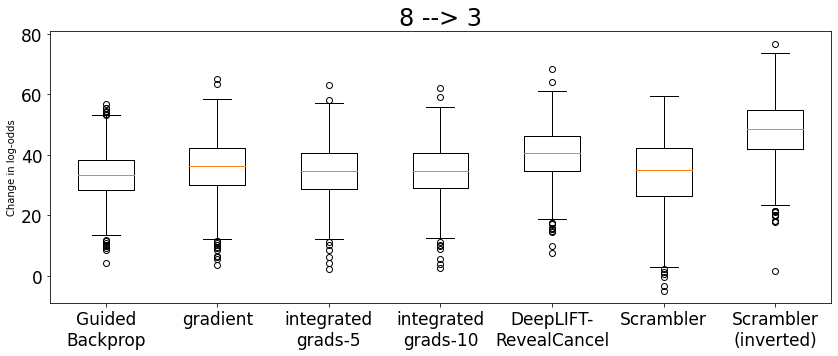

In [16]:
#DeepLIFT Notebook Cell 11

method_names_and_short_names = [
    #('simonyan_masked', '|grad|\n(Simonyan)'),
    #('guided_backprop_masked', 'Guided\nBackprop'),
    ('guided_backprop_times_inp', 'Guided\nBackprop'),
    ('grad_times_inp', 'gradient'),
    ('integrated_grads_5', 'integrated\ngrads-5'),
    ('integrated_grads_10', 'integrated\ngrads-10'),
    ('revealcancel', 'DeepLIFT-\nRevealCancel'),
    ('scrambler', 'Scrambler'),
    ('scrambler_inverted', 'Scrambler\n(inverted)'),
]

barplot_scores(8,3,method_names_and_short_names, n_to_erase)
